In [2]:
import tensorflow as tf
import os
import numpy as np
import sys

# --- 1. Configuration ---
# We reuse the folder we created previously to save time/space
BASE_DATA_DIR = './lsun_organized_resnext' 

# ConvNeXt standard input size is often 224, but 256 works great too.
# We will stick to 256 to match your previous setup.
IMG_SIZE = 256 
BATCH_SIZE = 32
NUM_CLASSES = 4

print(f"✅ Configuration Set:")
print(f"   Data Directory: {BASE_DATA_DIR}")
print(f"   Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")

# --- 2. GPU Check ---
print("\n🔍 Verifying GPU Status...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"   🔥 GPU Detected: {len(gpus)} device(s) - {gpus[0].name}")
    except RuntimeError as e:
        print(f"   ⚠️ GPU Error: {e}")
else:
    print("   ⚠️ No GPU detected. Training will be slow.")

# --- 3. ConvNeXt Library Check ---
print("\n📦 Checking for ConvNeXt Support...")

try:
    # We try to import from the external library that supports TF 2.10
    from keras_cv_attention_models import convnext
    print("   ✅ 'keras_cv_attention_models' found. ConvNeXt is ready to use.")
    
except ImportError:
    print("   ❌ Library 'keras_cv_attention_models' NOT found.")
    print("   ⚠️ ACTION REQUIRED: Please run the following command in a cell:")
    print("      !pip install keras-cv-attention-models")
    print("   (This is necessary because native ConvNeXt requires TensorFlow 2.11+, and you are likely on 2.10)")

print("\n🚀 Block 1 completed.")

✅ Configuration Set:
   Data Directory: ./lsun_organized_resnext
   Image Size: 256x256
   Batch Size: 32

🔍 Verifying GPU Status...
   🔥 GPU Detected: 1 device(s) - /physical_device:GPU:0

📦 Checking for ConvNeXt Support...
   ✅ 'keras_cv_attention_models' found. ConvNeXt is ready to use.

🚀 Block 1 completed.


c:\Users\301364822\AppData\Local\miniconda3\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# --- 1. Define Data Generators ---

print("⚙️ Setting up Data Generators for ConvNeXt (Scaling 0-1)...")

# ConvNeXt typically expects inputs in [0, 1], so we use rescale=1./255
# This replaces the missing 'preprocess_input' function.

# Training Data Generator (Augmentation enabled)
train_datagen = ImageDataGenerator(
    rescale=1./255,   # <--- FIX: Manual scaling to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test Data Generator (No augmentation, just rescaling)
val_test_datagen = ImageDataGenerator(
    rescale=1./255    # <--- FIX: Manual scaling to [0, 1]
)

# --- 2. Load Data ---
# Reusing the folder structure from the previous run
DATA_DIR = BASE_DATA_DIR 

print(f"📂 Loading data from: {DATA_DIR}")

# Training Generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Validation Generator
validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Test Generator
test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n📊 Data Summary:")
print(f"   Train Samples: {train_generator.samples}")
print(f"   Val Samples:   {validation_generator.samples}")
print(f"   Test Samples:  {test_generator.samples}")
print(f"   Classes: {list(train_generator.class_indices.keys())}")

print("\n🚀 Block 2 completed successfully.")

⚙️ Setting up Data Generators for ConvNeXt (Scaling 0-1)...
📂 Loading data from: ./lsun_organized_resnext
Found 84000 images belonging to 4 classes.
Found 18000 images belonging to 4 classes.
Found 18000 images belonging to 4 classes.

📊 Data Summary:
   Train Samples: 84000
   Val Samples:   18000
   Test Samples:  18000
   Classes: ['bedroom', 'dining_room', 'kitchen', 'living_room']

🚀 Block 2 completed successfully.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_cv_attention_models import convnext
import numpy as np

# --- Configuration ---
NUM_CLASSES = 4
LEARNING_RATE = 1e-3
MODEL_NAME = "ConvNeXtTiny"

print(f"🏗️ Building Model: {MODEL_NAME}")

# --- 1. Load Base Model ---
# num_classes=0 excludes the top layer (feature extraction mode)
# pretrained='imagenet' loads the weights
base_model = convnext.ConvNeXtTiny(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    num_classes=0, 
    pretrained="imagenet"
)

# --- 2. Freeze Base Model ---
# We freeze the backbone to train only the new head first
base_model.trainable = False
print(f"   Base model loaded and layers frozen.")

# --- 3. Build Classification Head ---
# The output of base_model (with num_classes=0) is the feature map.
# We need to pool it if the output is 4D (batch, height, width, channels)
# or if it's already pooled (batch, features), we can skip GAP.
# Let's check the output shape to be safe.

inputs = base_model.input
x = base_model.output

# ConvNeXtTiny in this library typically outputs features, so we ensure pooling
if len(x.shape) == 4:
    x = GlobalAveragePooling2D()(x)
    

x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create final model
model = Model(inputs=inputs, outputs=predictions)

# --- 4. Compile Model ---
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- 5. Summary ---
print("\n⚙️ Model Compilation Summary:")
print(f"   Optimizer: Adam (LR={LEARNING_RATE})")
trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"   Trainable Params (Head): {trainable_count:,}")
print(f"   Non-Trainable Params (Backbone): {non_trainable_count:,}")

print("\n🚀 Block 3 completed successfully.")

🏗️ Building Model: ConvNeXtTiny
114829704/114829704 [==============================] - 1s 0us/step
>>>> Load pretrained from: C:\Users\301364822\.keras\models\convnext_tiny_imagenet.h5
   Base model loaded and layers frozen.

⚙️ Model Compilation Summary:
   Optimizer: Adam (LR=0.001)
   Trainable Params (Head): 3,076
   Non-Trainable Params (Backbone): 27,818,592

🚀 Block 3 completed successfully.


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Configuration ---
EPOCHS_STAGE_1 = 10 
BATCH_SIZE = 32

# --- 1. Define Callbacks ---
print("⏱️ Setting up callbacks...")

# Checkpoint: Save best model based on Val Accuracy
checkpoint_path = "convnext_tiny_lsun_stage1_best.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Early Stopping: Stop if no improvement for 3 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Reduce LR: Drop learning rate if loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

# --- 2. Run Training ---
print(f"\n🚀 Starting Stage 1 Training (Head Only) for {EPOCHS_STAGE_1} epochs...")

history_1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_STAGE_1,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1
)

# --- 3. Save Final Weights ---
model.save_weights("convnext_tiny_lsun_stage1_final.h5")
print("\n✅ Stage 1 Training Complete.")
print("   Weights saved to 'convnext_tiny_lsun_stage1_final.h5'")

print("\n🚀 Block 4 completed successfully.")

⏱️ Setting up callbacks...

🚀 Starting Stage 1 Training (Head Only) for 10 epochs...
Epoch 1/10
2625/2625 [==============================] - ETA: 0s - loss: 0.5167 - accuracy: 0.8115
Epoch 1: val_accuracy improved from -inf to 0.89574, saving model to convnext_tiny_lsun_stage1_best.h5
2625/2625 [==============================] - 906s 339ms/step - loss: 0.5167 - accuracy: 0.8115 - val_loss: 0.2984 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 2/10
2625/2625 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.8391
Epoch 2: val_accuracy improved from 0.89574 to 0.90519, saving model to convnext_tiny_lsun_stage1_best.h5
2625/2625 [==============================] - 885s 337ms/step - loss: 0.4394 - accuracy: 0.8391 - val_loss: 0.2651 - val_accuracy: 0.9052 - lr: 0.0010
Epoch 3/10
2625/2625 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.8391
Epoch 3: val_accuracy improved from 0.90519 to 0.90731, saving model to convnext_tiny_lsun_stage1_best.h5
2625/2

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Configuration ---
LEARNING_RATE_STAGE_2 = 1e-5 
EPOCHS_STAGE_2 = 30 # <--- Increased to 30 as requested
EPOCHS_TOTAL = EPOCHS_STAGE_1 + EPOCHS_STAGE_2

print(f"🔓 Preparing for Stage 2: Fine-Tuning (Total Epoch limit: {EPOCHS_STAGE_2})...")
print("   (Note: Early Stopping is active, so it may stop sooner if accuracy peaks.)")

# --- 1. Unfreeze the Entire Model ---
base_model.trainable = True
print(f"   All layers unfrozen. The model is now fully trainable.")

# --- 2. Re-Compile the Model ---
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_STAGE_2),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print(f"   Model Re-compiled with Low LR ({LEARNING_RATE_STAGE_2})")

# --- 3. Define Callbacks for Stage 2 ---
checkpoint_path_2 = "convnext_tiny_lsun_stage2_best.h5"

callbacks_list_2 = [
    ModelCheckpoint(
        checkpoint_path_2,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=4, # Slightly more patience for fine details
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# --- 4. Run Training (Stage 2) ---
print(f"\n🚀 Starting Stage 2 Training (Fine-Tuning) for {EPOCHS_STAGE_2} epochs...")

history_2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_TOTAL,
    initial_epoch=EPOCHS_STAGE_1, # Ensures graphs start at epoch 11, not 1
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list_2,
    verbose=1
)

# --- 5. Save Final Model ---
model.save("convnext_tiny_lsun_final_model.h5")
print("\n✅ Stage 2 Training Complete.")
print("   Final Full Model saved to 'convnext_tiny_lsun_final_model.h5'")

print("\n🚀 Block 5 completed successfully.")

🔓 Preparing for Stage 2: Fine-Tuning (Total Epoch limit: 30)...
   (Note: Early Stopping is active, so it may stop sooner if accuracy peaks.)
   All layers unfrozen. The model is now fully trainable.
   Model Re-compiled with Low LR (1e-05)

🚀 Starting Stage 2 Training (Fine-Tuning) for 30 epochs...
Epoch 11/40
2625/2625 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.9011
Epoch 11: val_accuracy improved from -inf to 0.93700, saving model to convnext_tiny_lsun_stage2_best.h5
2625/2625 [==============================] - 1303s 491ms/step - loss: 0.2817 - accuracy: 0.9011 - val_loss: 0.1828 - val_accuracy: 0.9370 - lr: 1.0000e-05
Epoch 12/40
2625/2625 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9211
Epoch 12: val_accuracy improved from 0.93700 to 0.94006, saving model to convnext_tiny_lsun_stage2_best.h5
2625/2625 [==============================] - 1287s 490ms/step - loss: 0.2251 - accuracy: 0.9211 - val_loss: 0.1728 - val_accuracy: 0.94

🚀 Running predictions on the Test Set...
563/563 [==============================] - 92s 161ms/step

✅ Final Test Set Accuracy: 94.14%

📊 Classification Report:
              precision    recall  f1-score   support

     bedroom       0.97      0.96      0.97      4500
 dining_room       0.92      0.91      0.92      4500
     kitchen       0.94      0.95      0.95      4500
 living_room       0.93      0.94      0.94      4500

    accuracy                           0.94     18000
   macro avg       0.94      0.94      0.94     18000
weighted avg       0.94      0.94      0.94     18000


📉 Generating Confusion Matrix...


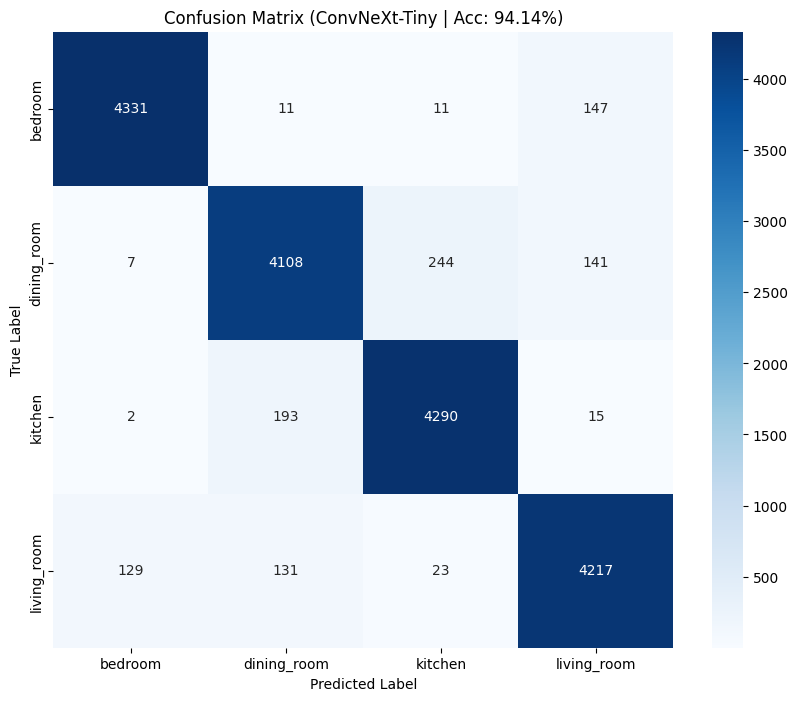


🚀 Block 6 completed.


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Run Predictions on Test Set ---
print("🚀 Running predictions on the Test Set...")

# Reset generator to ensure order alignment
test_generator.reset()

# Get Predictions (Probabilities)
predictions = model.predict(test_generator, verbose=1)

# Convert probabilities to Class Indices
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# --- 2. Calculate Final Accuracy ---
errors = np.where(y_pred != y_true)[0]
accuracy = (1 - len(errors)/len(y_true)) * 100
print(f"\n✅ Final Test Set Accuracy: {accuracy:.2f}%")

# --- 3. Classification Report ---
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- 4. Plot Confusion Matrix ---
print("\n📉 Generating Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix (ConvNeXt-Tiny | Acc: {accuracy:.2f}%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\n🚀 Block 6 completed.")

📊 Generating Training Graphs...


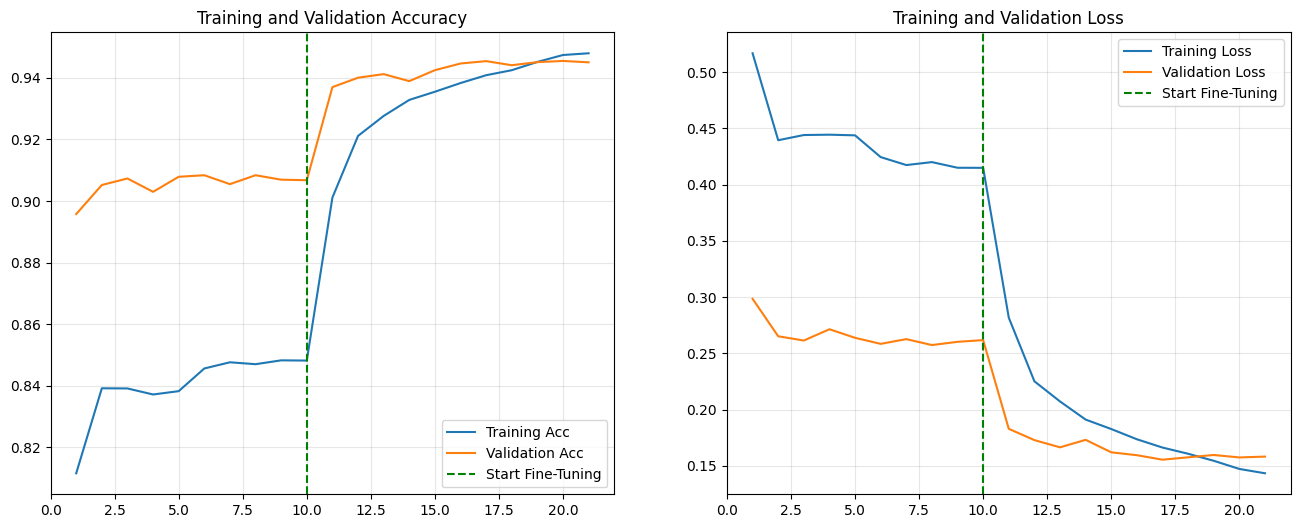

🚀 Block 7 completed.


In [9]:
import matplotlib.pyplot as plt

def plot_history(history1, history2):
    # Combine history data
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs_range = range(1, len(acc) + 1)
    fine_tune_start = len(history1.history['accuracy']) 

    plt.figure(figsize=(16, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Acc')
    plt.plot(epochs_range, val_acc, label='Validation Acc')
    plt.axvline(x=fine_tune_start, color='green', linestyle='--', label='Start Fine-Tuning')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=fine_tune_start, color='green', linestyle='--', label='Start Fine-Tuning')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.show()

print("📊 Generating Training Graphs...")
plot_history(history_1, history_2)
print("🚀 Block 7 completed.")

⚙️ Computing ROC and PR Curves...


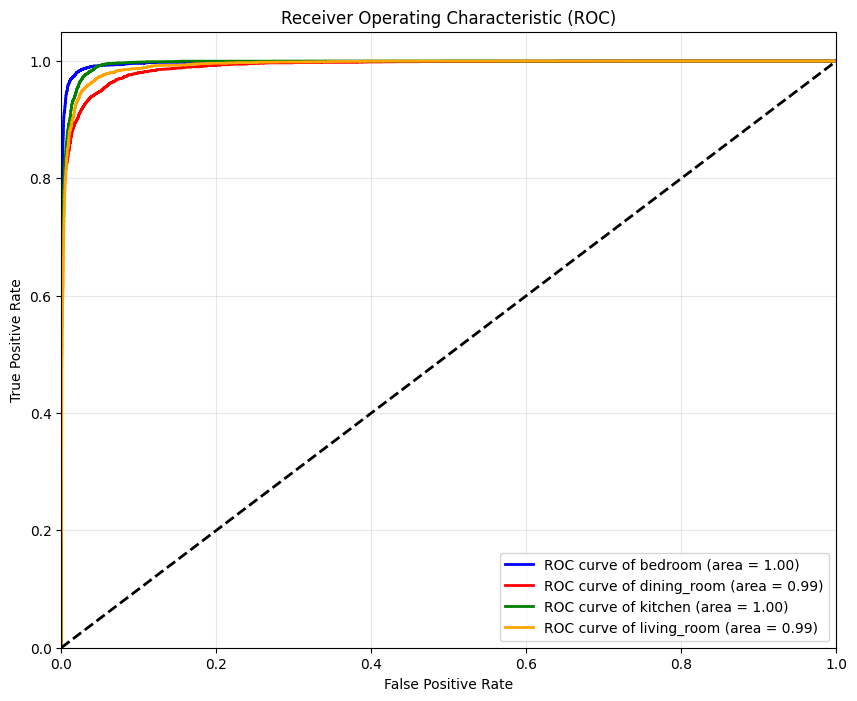

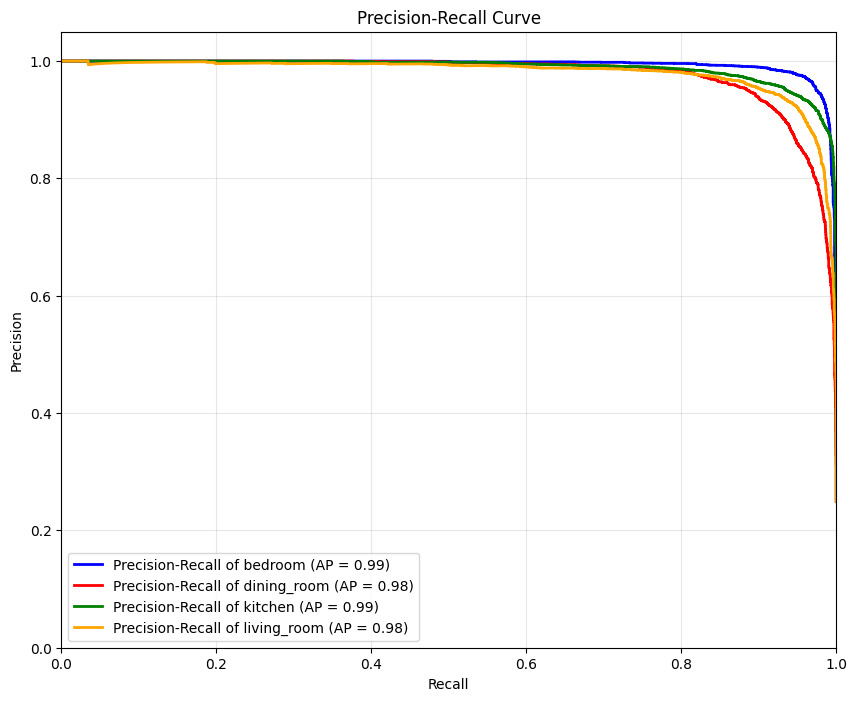

🚀 Block 8 completed.


In [10]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.utils import to_categorical
from itertools import cycle

# --- Prepare Data ---
print("⚙️ Computing ROC and PR Curves...")
y_true_one_hot = to_categorical(y_true, num_classes=NUM_CLASSES)
n_classes = len(class_names)

# --- Plot ROC Curve ---
plt.figure(figsize=(10, 8))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot Precision-Recall Curve ---
plt.figure(figsize=(10, 8))
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_one_hot[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(y_true_one_hot[:, i], predictions[:, i])

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall of {class_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

print("🚀 Block 8 completed.")

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

# --- 1. Library Setup ---
try:
    from keras_cv_attention_models import convnext
except ImportError:
    print("⚠️ Library 'keras_cv_attention_models' not found. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "keras_cv_attention_models"])
    from keras_cv_attention_models import convnext

# --- 2. Configuration ---
IMG_SIZE = 256
NUM_CLASSES = 4
CLASS_LABELS = ['bedroom', 'dining_room', 'kitchen', 'living_room']
# Path to your best saved weights for ConvNeXt
WEIGHTS_PATH = 'convnext_tiny_lsun_stage2_best.h5' 

# --- 3. Function to Reconstruct Model and Load Weights ---
def load_trained_model(weights_path):
    print(f"🏗️ Reconstructing ConvNeXt-Tiny architecture...")
    
    # 1. Build Base (num_classes=0 excludes top, pretrained=None is fine as we load weights)
    base_model = convnext.ConvNeXtTiny(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        num_classes=0, 
        pretrained=None 
    )
    
    # 2. Build Head (Must match training structure exactly)
    # Note: We check if pooling is needed just like in training
    x = base_model.output
    if len(x.shape) == 4:
        x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # 3. Create Model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # 4. Load Weights
    print(f"📂 Loading weights from: {weights_path}")
    if os.path.exists(weights_path):
        model.load_weights(weights_path)
        print("✅ Weights loaded successfully.")
    else:
        raise FileNotFoundError(f"❌ Weights file not found at: {weights_path}")
        
    return model

# --- 4. Prediction Function ---
def predict_image(image_path, model):
    """
    Loads an image, scales to [0, 1], and predicts class.
    """
    try:
        # Load and Resize
        img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
        
        # Convert to Array
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        
        # Preprocess: ConvNeXt in this setup expects [0, 1] scaling
        img_preprocessed = img_batch / 255.0
        
        # Predict
        predictions = model.predict(img_preprocessed, verbose=0)
        predicted_class_idx = np.argmax(predictions)
        confidence = np.max(predictions)
        predicted_label = CLASS_LABELS[predicted_class_idx]
        
        # Visualize
        plt.figure(figsize=(6, 6))
        plt.imshow(image.load_img(image_path))
        plt.axis('off')
        plt.title(f"Pred: {predicted_label.upper()} ({confidence*100:.2f}%)")
        plt.show()
        
        print(f"✅ Prediction: {predicted_label}")
        print(f"📊 Confidence Scores: {dict(zip(CLASS_LABELS, np.round(predictions[0], 4)))}")
        
    except Exception as e:
        print(f"⚠️ Error processing image: {e}")



⚠️ Library 'keras_cv_attention_models' not found. Installing...
[WARNING] Currently tensorflow>=2.16 with keras 3 not supported, try pip install tf-keras~=2.16 and set TF_USE_LEGACY_KERAS=1 if error.


🏗️ Reconstructing ConvNeXt-Tiny architecture...
📂 Loading weights from: convnext_tiny_lsun_stage2_best.h5
✅ Weights loaded successfully.


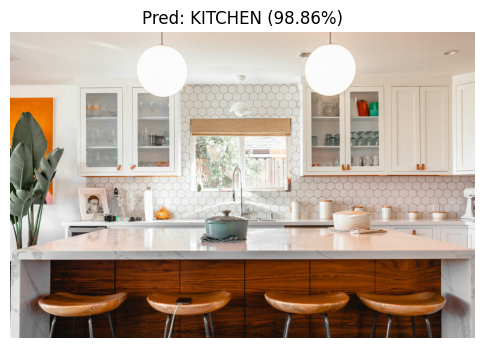

✅ Prediction: kitchen
📊 Confidence Scores: {'bedroom': np.float32(0.0), 'dining_room': np.float32(0.0114), 'kitchen': np.float32(0.9886), 'living_room': np.float32(0.0)}


In [2]:
# ==========================================
# MAIN EXECUTION
# ==========================================

try:
    # 1. Load the model
    model_inference = load_trained_model(WEIGHTS_PATH)
    
    # 2. Example Usage (Uncomment and set path to test)
    test_image_path = "Kitchen_1.jpg"
    if os.path.exists(test_image_path):
        predict_image(test_image_path, model_inference)
        

except Exception as e:
    print(f"\n❌ Setup Failed: {e}")